Part1:

In [1]:
#import all my stuff
import numpy as np
import math
import copy
from collections import Counter

In [2]:
def read_train(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        token_seq , tag_seq , current_token , current_tag = [],[],[],[]
        for line in file:
            token_tag = line.strip().split(" ")

            if len(token_tag) == 2:
                current_token += [token_tag[0]]
                current_tag += [token_tag[1]]
            else:
                token_seq += [current_token]
                tag_seq += [current_tag]
                current_token = []
                current_tag = []
        if (len(current_token) != 0):
            token_seq += [current_token]
            tag_seq += [current_tag]
    return token_seq, tag_seq

def read_test(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        token_seq , current_token = [],[]
        for line in file:
            token_test = line.strip()

            if len(token_test) !=0:
                current_token += [token_test]
                
            else:
                token_seq += [current_token]
                current_token = []  

        if (len(current_token) != 0):
            token_seq += [current_token]
            
    return token_seq

def create_emission_dictionary(token_seq, tag_seq,k):
    emission_dictionary = {} 
    count_tag = {} #number of words tagged with tag
    count_token_tagged_tag = {} #number of times a token is tagged with tag
    for i in range(0,len(token_seq)):
        for j in range(0, len(token_seq[i])):
            x = token_seq[i][j]
            y = tag_seq[i][j]
            if not (y in count_tag.keys()):
                count_tag[y] = 0

            count_tag[y] += 1

            if not (x in count_token_tagged_tag.keys()):
                count_token_tagged_tag[x] = {}

            if not (y in count_token_tagged_tag[x].keys()):
                count_token_tagged_tag[x][y] = 0

            count_token_tagged_tag[x][y] += 1
    
    for i in range(0, len(token_seq)):
        for j in range(0, len(token_seq[i])):
            x = token_seq[i][j]
            y = tag_seq[i][j]
            if not(x in emission_dictionary.keys()):
                emission_dictionary[x] = {}
            emission_dictionary[x][y] = (count_token_tagged_tag[x][y]) / (count_tag[y] + k)
            emission_dictionary[x]["START"] = 0
            emission_dictionary[x]["STOP"] = 0

    emission_dictionary["#UNK#"] = {}
    for tag in count_tag.keys():
        emission_dictionary["#UNK#"][tag] = k / (count_tag[tag] + k)
    uniquetags = list(count_tag.keys())
    return emission_dictionary , uniquetags

def emission(token, tag, emission_dictionary, uniquetags):
    if not (tag in uniquetags):
        return 0
    elif not (token in emission_dictionary.keys()):
        return emission_dictionary["#UNK#"][tag]
    else:
        if not (tag in emission_dictionary[token].keys()):
            emission_dictionary[token][tag] = 0
        return emission_dictionary[token][tag]


def simple_sentiment_analysis(test_token,emission_dictionary, uniquetags):
    predicted_tags = []
    for token_seq in test_token:
        current_token = []
        for token in token_seq:
            predicted_tag = ""
            max_prob = 0
            for tag in uniquetags:
                prob = emission(token, tag, emission_dictionary, uniquetags)
                if prob > max_prob:
                    max_prob = prob
                    predicted_tag = tag
            current_token += [predicted_tag]
        predicted_tags += [current_token]
        current_token = []
    return predicted_tags

def writeoutput(filename, tokens, predicted_tags):
  with open(filename, 'w', encoding='utf-8') as file:

    for i in range(0,len(tokens)):
      for j in range(0,len(tokens[i])):
        file.write(tokens[i][j] + " " + predicted_tags[i][j] + "\n" )

      file.write("\n")

In [5]:
es_token_seq, es_tag_seq = read_train("ES/train")
es_emission_dictionary, es_unique_tags = create_emission_dictionary(es_token_seq, es_tag_seq, 1)
es_test_token_seq = read_test("ES/dev.in")

es_predicted_tags = simple_sentiment_analysis(es_test_token_seq, es_emission_dictionary, es_unique_tags)

writeoutput("ES/dev.p1.out", es_test_token_seq, es_predicted_tags)

!python "evalResult.py" "ES/dev.out" "ES/dev.p1.out"


#Entity in gold data: 229
#Entity in prediction: 1466

#Correct Entity : 178
Entity  precision: 0.1214
Entity  recall: 0.7773
Entity  F: 0.2100

#Correct Sentiment : 97
Sentiment  precision: 0.0662
Sentiment  recall: 0.4236
Sentiment  F: 0.1145


In [6]:
ru_token_seq, ru_tag_seq = read_train("RU/train")
ru_emission_dictionary, ru_unique_tags = create_emission_dictionary(ru_token_seq, ru_tag_seq, 1)
ru_test_token_seq = read_test("RU/dev.in")

ru_predicted_tags = simple_sentiment_analysis(ru_test_token_seq, ru_emission_dictionary, ru_unique_tags)

writeoutput("RU/dev.p1.out", ru_test_token_seq, ru_predicted_tags)

!python "evalResult.py" "RU/dev.out" "RU/dev.p1.out"


#Entity in gold data: 389
#Entity in prediction: 1816

#Correct Entity : 266
Entity  precision: 0.1465
Entity  recall: 0.6838
Entity  F: 0.2413

#Correct Sentiment : 129
Sentiment  precision: 0.0710
Sentiment  recall: 0.3316
Sentiment  F: 0.1170


Part2

In [7]:
#takes in my array of tags and return dictionary that gives trasnsition param

def create_transition_dictionary(tag_seq, unique_tags):
    transition_dictionary = {}

    for first_tag in unique_tags:
        for second_tag in unique_tags:
            count, total = 0, 0
            for i in tag_seq:
                total += len(i) - 1
                for j in range(len(i) - 1):
                    if i[j] == first_tag and i[j+1] == second_tag:
                        count += 1
            if count != 0:
                transition_dictionary[(first_tag, second_tag)] = count / total

    start_dict = Counter(i[0] for i in tag_seq)
    stop_dict = Counter(i[-1] for i in tag_seq)

    total_sentences = len(tag_seq)

    for tag, count in start_dict.items():
        transition_dictionary[('START', tag)] = count / total_sentences

    for tag, count in stop_dict.items():
        transition_dictionary[(tag, 'STOP')] = count / total_sentences

    return transition_dictionary
    


In [8]:
def transition(transition_dict, previous_tag, current_tag):
    transition_key = (previous_tag, current_tag)
    
    if transition_key not in transition_dict:
        transition_dict[transition_key] = math.log(1)
    
    return transition_dict[transition_key]


def emission(token, tag, emission_dictionary, uniquetags):
    if tag not in uniquetags:
        return math.log(1)
    elif token not in emission_dictionary:
        return emission_dictionary["#UNK#"][tag]
    elif tag not in emission_dictionary[token]:
        return math.log(1)
    else:
        return emission_dictionary[token][tag]


def viterbi(test_token_seq_sentence, unique_tags, emission_dictionary, transition_dictionary):
    viterbi_probs = {0: {"START": math.log(1)}, **{i: {tag: -math.inf for tag in unique_tags} for i in range(1, len(test_token_seq_sentence) + 1)}}
    
    # Calculate probabilities for each tag in the first word
    for tag in unique_tags:
        emission_prob = emission(test_token_seq_sentence[0], tag, emission_dictionary, unique_tags)
        transition_prob = transition(transition_dictionary, "START", tag)
        
        if emission_prob == 0 or transition_prob == 0:
            viterbi_probs[1][tag] = -math.inf
        else:
            viterbi_probs[1][tag] = math.log(emission_prob) + math.log(transition_prob) + viterbi_probs[0]["START"]
            
    # Calculate probabilities for each tag in the rest of the words
    for i in range(1, len(test_token_seq_sentence)):
        next_token = test_token_seq_sentence[i]
        for j in unique_tags:
            max_prob = -math.inf
            for k in unique_tags:
                emission_prob = emission(next_token, j, emission_dictionary, unique_tags)
                transition_prob = transition(transition_dictionary, k, j)
                
                if emission_prob == 0 or transition_prob == 0:
                    prob = -math.inf
                else:
                    prob = math.log(emission_prob) + math.log(transition_prob) + viterbi_probs[i][k]
                
                if prob > max_prob:
                    max_prob = prob
            viterbi_probs[i+1][j] = max_prob
    
    # Calculate probabilities for transitioning to the "STOP" tag
    max_prob = -math.inf
    for tag in unique_tags:
        previous_prob = viterbi_probs[len(test_token_seq_sentence)][tag]
        transition_prob = transition(transition_dictionary, tag, "STOP")
        
        if transition_prob == 0:
            prob = -math.inf
        else:
            prob = previous_prob + math.log(transition_prob)
        
        if prob > max_prob:
            max_prob = prob
    viterbi_probs[len(test_token_seq_sentence)+1] = {}
    viterbi_probs[len(test_token_seq_sentence)+1]["STOP"] = max_prob
    
    # Backtracking to find the best path
    best_path = []
    argmax = -math.inf
    currentmax = -math.inf
    argmax_tag = "NULL"

    for tag in unique_tags:
        prob = viterbi_probs[len(test_token_seq_sentence)][tag]
        transition_prob = transition(transition_dictionary, tag, "STOP")
        if transition_prob != 0:
            currentmax = prob + math.log(transition_prob)
            
            if currentmax > argmax:
                argmax = currentmax
                argmax_tag = tag

    best_path.append(argmax_tag)
    
    # Backpropagation
    for i in range(len(test_token_seq_sentence), 1, -1):
        argmax = -math.inf
        currentmax = math.log(1)
        
        for tag in unique_tags:
            prob = viterbi_probs[i-1][tag]
            transition_prob = transition(transition_dictionary, tag, best_path[-1])
            
            if transition_prob == 0:
                currentmax = -math.inf
            else:
                currentmax = prob + math.log(transition_prob)
            
            if currentmax > argmax:
                argmax = currentmax
                argmax_tag = tag
        best_path.append(argmax_tag)

    best_path.reverse()
    return best_path

def viterbi_loop(test_token_seq, unique_tags, emission_dictionary, transition_dictionary):
    result = []

    for sentence in test_token_seq:
        viterbi_tags = viterbi(sentence, unique_tags, emission_dictionary, transition_dictionary)
        updated_tags = handle_null_tags(sentence, viterbi_tags, unique_tags, emission_dictionary)
        result.append(updated_tags)
    
    return result

def handle_null_tags(sentence, viterbi_tags, unique_tags, emission_dictionary):
    updated_tags = []

    for i in range(len(sentence)):
        if viterbi_tags[i] == "NULL":
            word = sentence[i]
            max_emission_value = -math.inf
            best_emission_tag = None

            for tag in unique_tags:
                emission_prob = emission(word, tag, emission_dictionary, unique_tags)
                if emission_prob > max_emission_value:
                    max_emission_value = emission_prob
                    best_emission_tag = tag

            if best_emission_tag is not None:
                updated_tags.append(best_emission_tag)
            else:
                # If no valid emission tag found, keep the original "NULL" tag
                updated_tags.append(viterbi_tags[i])
        else:
            updated_tags.append(viterbi_tags[i])
    
    return updated_tags

In [9]:

es_token_seq, es_tag_seq = read_train("ES/train")
es_emission_dictionary, es_unique_tags = create_emission_dictionary(es_token_seq, es_tag_seq, 1)
es_test_token_seq = read_test("ES/dev.in")   
es_transition_dictionary = create_transition_dictionary(es_tag_seq, es_unique_tags)
es_predicted_tags_viterbi = viterbi_loop(es_test_token_seq, es_unique_tags, es_emission_dictionary, es_transition_dictionary)
writeoutput("ES/dev.p2.out", es_test_token_seq, es_predicted_tags_viterbi)


!python "evalResult.py" "ES/dev.out" "ES/dev.p2.out"


#Entity in gold data: 229
#Entity in prediction: 25

#Correct Entity : 11
Entity  precision: 0.4400
Entity  recall: 0.0480
Entity  F: 0.0866

#Correct Sentiment : 10
Sentiment  precision: 0.4000
Sentiment  recall: 0.0437
Sentiment  F: 0.0787


In [10]:
ru_token_seq, ru_tag_seq = read_train("RU/train")
ru_emission_dictionary, ru_unique_tags = create_emission_dictionary(ru_token_seq, ru_tag_seq, 1)
ru_test_token_seq = read_test("RU/dev.in")   
ru_transition_dictionary = create_transition_dictionary(ru_tag_seq, ru_unique_tags)
ru_predicted_tags_viterbi = viterbi_loop(ru_test_token_seq, ru_unique_tags, ru_emission_dictionary, ru_transition_dictionary)
writeoutput("RU/dev.p2.out", ru_test_token_seq, ru_predicted_tags_viterbi)
!python "evalResult.py" "RU/dev.out" "RU/dev.p2.out"



#Entity in gold data: 389
#Entity in prediction: 123

#Correct Entity : 56
Entity  precision: 0.4553
Entity  recall: 0.1440
Entity  F: 0.2187

#Correct Sentiment : 43
Sentiment  precision: 0.3496
Sentiment  recall: 0.1105
Sentiment  F: 0.1680


Part3: 

# Question 4 
Our approach is to train a new pytorch model 
We set 100 to the embedding dimension to have a better range of sensitivity to the relationships between each possible node
and set 200 to the hidden dimension for a 200 layer RNN

We set epoch to be 800 as it starts plateauing thereafter and batchsize to be 1000 to not be too big or too small for a stable gradient that is still sensitive to changes between dataset.

It is trained using gpu on google collab link below

https://colab.research.google.com/drive/1dsjMv1zOb1ruNEn0AfuFfSgZ1Kv1sYSo?usp=sharing

We then loaded each test.in for RU and ES.

To evaluate and generate the tags use the model russian_final.pt and espanol_final.pt

In [18]:
# reformat to a df
import pandas as pd
ru_token_seq, ru_tag_seq = read_train("RU/train")
es_token_seq, es_tag_seq = read_train("ES/train")

ru_token_seq = pd.DataFrame(ru_token_seq)


In [23]:
# Trained using google collab
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

class Sentimenttagging(Dataset):
    def __init__(self, word_sequences, tag_sequences):
        self.word_sequences = word_sequences
        self.tag_sequences = tag_sequences

    def __len__(self):
        return len(self.word_sequences)

    def __getitem__(self, idx):
        words = torch.LongTensor(self.word_sequences[idx])
        tags = torch.LongTensor(self.tag_sequences[idx])
        return words, tags

    def collate_fn(self, batch):
        # Sort batch by sequence length (descending)
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        words, tags = zip(*batch)

        # Pad sequences
        words_padded = nn.utils.rnn.pad_sequence(words, batch_first=True)
        tags_padded = nn.utils.rnn.pad_sequence(tags, batch_first=True)

        return words_padded, tags_padded
    
#  Inititate Torch Model
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tag_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

cpu
Epoch 1/1, Loss: 1.416395664215088


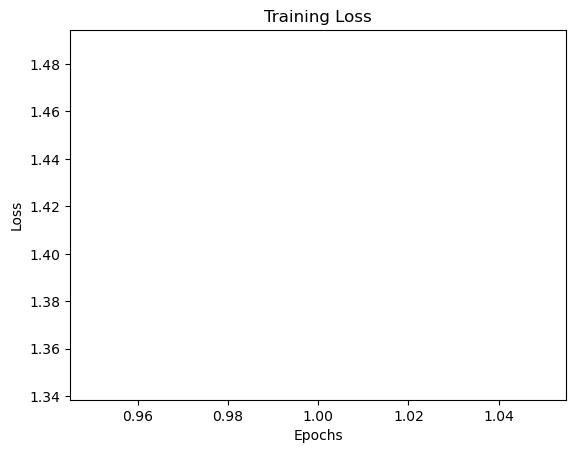

In [28]:
#DO NOT RUN
    
# Sample word_sequences = ['Еда', 'вкусная', ',', 'но', 'отдельно', 'хочу', 'отметить', 'красивую', 'сервировку', 'блюд', ';', '.']
# Sample tag_sequences = ['B-positive', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-positive', 'I-positive', 'O', 'O']
    
# Set ur file path for ur train sequence
word_sequences , tag_sequences = read_train("ES/train")

# Word mappings and index
word_to_idx = {}  
tag_to_idx = {}   

# Iterate through the word and tag sequences to populate the dictionaries
for sentence in word_sequences:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)

for tags in tag_sequences:
    for tag in tags:
        if tag not in tag_to_idx:
            tag_to_idx[tag] = len(tag_to_idx)

word_sequences = [[word_to_idx[word] for word in seq] for seq in word_sequences]
tag_sequences = [[tag_to_idx[tag] for tag in seq] for seq in tag_sequences]




vocab_size = len(word_to_idx)
tag_size = len(tag_to_idx)
embedding_dim = 100
hidden_dim = 200
# Create the dataset and DataLoader
dataset = Sentimenttagging(word_sequences, tag_sequences)
dataloader = DataLoader(dataset, batch_size=1000, collate_fn=dataset.collate_fn)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = SentimentModel(vocab_size, tag_size, embedding_dim, hidden_dim)
model.to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)


epochs = 1
loss_list = []


for epoch in range(epochs):
    for words, tags in dataloader:
        # Convert words and tags to tensors
        # words = torch.LongTensor(words)
        # tags = torch.LongTensor(tags)
        words = words.to(device)  
        tags = tags.to(device)    
        

        # Forward pass
        outputs = model(words)

        # Compute the loss
        loss = criterion(outputs.view(-1, tag_size), tags.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    loss_list.append(loss.item())
    
model_save_path = "test.pt" #set ur own
torch.save(model.state_dict(), model_save_path)    
plt.plot(range(1, epochs + 1), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()







In [13]:
# Do training 

In [29]:
#reload to check
model_save_path = "espanol_final.pt"


loaded_model = SentimentModel(vocab_size, tag_size, 100, 200)
loaded_model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
loaded_model.eval()  # Set the model to evaluation mode

def convert_text_to_indices(text, word_to_idx):
    if type(text) == list :
        words = text
    else:
        words = text.split()
    default_idx = word_to_idx.get("O", 0)  # Use index 0 as default for unknown words
    indices = [word_to_idx.get(word, default_idx) for word in words]
    return indices

def predict_text_sequence(model, text, word_to_idx):
    model.eval()
    with torch.no_grad():
        indices = convert_text_to_indices(text, word_to_idx)
        inputs = torch.LongTensor(indices).unsqueeze(0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 2)
        return predicted.squeeze().tolist()


In [30]:
def read_test(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        token_seq, current_token = [], []
        for line in file:
            token = line.strip()  # Assuming each line is a token

            if token:
                current_token.append(token)
            else:
                if current_token:
                    token_seq.append(current_token)
                    current_token = []

        if current_token:
            token_seq.append(current_token)
            
    return token_seq
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

ru_test_token = read_test("ES/test.in")
print(len(ru_test_token))
print(ru_test_token)
label_list = []
predictions=[]
for index , each_sentence in enumerate(ru_test_token) :
    print(each_sentence)
    predictions = predict_text_sequence(loaded_model, each_sentence, word_to_idx)
    if len(each_sentence) == 1:
        predictions = [predictions]
    print(predictions)
    # Convert predicted indices to tag labels
    predicted_tags = [idx_to_tag[idx] for idx in predictions]
    print(len(each_sentence),len(predictions))
    label_list.append(predicted_tags)
print(label_list)

FileNotFoundError: [Errno 2] No such file or directory: 'test/ES/test.in'